# Connect

In [ ]:
# https://chat.openai.com/share/b0ec97ff-b2e8-4efb-8a07-8aa9c32a61dc

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Install

In [ ]:
!pip install numpy
!pip install nltk>=3.4.5
!pip install tqdm

In [ ]:
!pip install transformers

In [ ]:
!git clone https://github.com/google-research/bleurt.git
!cd bleurt
!cd bleurt
!pip install ./bleurt
!wget https://storage.googleapis.com/bleurt-oss-21/BLEURT-20-D3.zip .
!unzip 'BLEURT-20-D3.zip'

Cloning into 'bleurt'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 134 (delta 0), reused 17 (delta 0), pack-reused 116
Receiving objects: 100% (134/134), 31.28 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Processing ./bleurt
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.0 MB/s eta 0:00:00
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456765 sha256=ea7f18e0c8e5fa5299091b91034cd8a3d312da8185daaaa0f8f116fd8ae53544
  Stored in directory: /tmp/pip-ephem-wheel-cache-9b_mjiz7/wheels/92/4f/fb/afa555fa27aa9e2c7958df797a62cc4e74f0f459cec9c4fa7c
Successfully built BLEURT
--2024-01-24 18:12:07--  https://storage.googleapis.com/bleurt-oss-21/BLEURT-20-D3.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.goo

# Imports

In [ ]:
import re
import nltk
import datetime,time
import pandas as pd
import string
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import (AdamW, AutoTokenizer,AutoModelForSeq2SeqLM,
                          T5ForConditionalGeneration, T5Tokenizer, MT5ForConditionalGeneration,
                          AutoConfig, AutoModelForCausalLM,
                          get_linear_schedule_with_warmup)
from transformers.optimization import Adafactor, AdafactorSchedule

import random
import os

from bleurt import score
from sklearn.metrics import f1_score


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)


#Connect to wandb

In [ ]:
wandb_key = '0529a3ad694a5487302b30b185aebe0c349aa1da'

In [ ]:
!pip install wandb
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.2 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

In [ ]:
!nvidia-smi

Wed Jan 24 18:12:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Config

In [ ]:
class config:
  DATASET_LABELED_PATH = '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/dataset/ro/ro_aspects_combine_on_a_line.csv'
  DATASET_pseudoLABELED_PATH_FINAL = '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/dataset/ro/pseudolabeled_reviews.csv'
  DATASET_FINAL_SAVE_PATH = '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/dataset/ro/labeled_reviews_by_student.csv'

  MODEL_ATE_PATH = '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/models/ate_enroaug_cat_v6.pt'
  MODEL_STUDENT_SAVE_PATH = '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/models/ate_stud_ro_v1.pt'
  PRE_TRAINED_TOKENIZER_NAME ='google/mt5-base'
  MODEL_BASE ='google/mt5-base'
  bleurt_checkpoint = './BLEURT-20-D3'

  PROMPT = 'Extract a list with the text spans that are aspect terms, from the following Romanian text: '  # aspect terms/categories

  MAX_SOURCE_LEN = 512
  MAX_TARGET_LEN = 15

  BATCH_SIZE_TRAIN_LBL = 4
  BATCH_SIZE_TRAIN_ULBL = 4
  BATCH_SIZE_TEST = 2

  EPOCHS=3
  LR = [1e-4, 3e-4]
  EPS = 1e-5
  LOSS_WEIGHT = 0.5

  DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Read data

AIM: LEARN THE MODEL TO PREDICT ALL ASPECT CATEGORIES FROM A TEXT

In [ ]:
df_lbl = pd.read_csv(config.DATASET_LABELED_PATH)
df_ulbl =  pd.read_csv(config.DATASET_pseudoLABELED_PATH_FINAL)

In [ ]:
df_lbl.drop(columns=['Unnamed: 0.1','Unnamed: 0'], inplace=True)
df_ulbl.drop(columns=['Unnamed: 0.1','Unnamed: 0'], inplace=True)

df_ulbl.rename(columns={'pseudo_all_categories':'all_categories'}, inplace=True)
df_lbl.rename(columns={'text_review':'text'}, inplace=True)

df_lbl['type'] = 'labeled'
df_ulbl['type'] = 'paseudo-labeled'

df_lbl.dropna(subset=['text'],inplace=True)
df_ulbl.dropna(subset=['text'],inplace=True)
len(df_ulbl), len(df_lbl)

(15943, 999)

In [ ]:
df_lbl.head(1)

,id,text,aspect,polarity_aspect,category_aspect,all_aspects,all_categories,type
0,a.3zUCvkq5sMQniYGQsF1S7cuIRq-2979133___rating_...,Sunt foarte multumita de acest magazin.ma bucu...,Sunt foarte multumita de acest magazin,1.0,magazin,Sunt foarte multumita de acest magazin; recoma...,magazin; magazin;,labeled


In [ ]:
df_ulbl.head(1)

,text,most_inner_category,rating,all_categories,type
0,"Castile astea le am de la final de 2021, deci ...",GamingHeadset,4,experienta;calitate,paseudo-labeled


# Utils methods

https://colab.research.google.com/drive/110SZGBXDNT9OpL_T-DddHfy1E6tYHGh3#scrollTo=wRIk4iZOkSp0

In [ ]:
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')
punctuation = string.punctuation
punctuation = re.sub('-','',punctuation)
punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [ ]:
def clean_df(df, text_col_name):
    df[text_col_name] = df[text_col_name].apply(lambda x: x.lower())
    df[text_col_name] = df[text_col_name].apply(lambda x: re.sub(r'\s([?.!"](?:\s|$))', r'\1', x))
    df[text_col_name] = df[text_col_name].apply(lambda x: re.sub(r'(http|https|www)\S+', ' HTTPURL ', x))
    df[text_col_name] = df[text_col_name].apply(lambda x: " ".join(x.split()))
    df[text_col_name] =  config.PROMPT + df[text_col_name] + ' </s>'
    return df

In [ ]:
def clean_predictions(pred):
    stop_words = ['the','i','a','or',')','un','o',' ']
    # print(pred)
    pred = pred.split(';')
    pred_new = []
    for x in pred:
      if x!= ' ':
        tokens = word_tokenize(x)
        tokens = [t for t in tokens if t.lower() not in stop_words]
        tokens = ' '.join(tokens)
        tokens = re.sub(r'\)',' ', tokens)
        tokens = re.sub(r'\(',' ', tokens)
        tokens = re.sub(' +', ' ', tokens)
        tokens = tokens.translate(str.maketrans('', '', punctuation))
        tokens = tokens.strip()
        if tokens != ' ':
          pred_new.append(tokens.strip())
    return pred_new

In [ ]:
def f1(pred, target):
  return f1_score(target, pred, average='weighted')

def recall(pred, target):
  sum = 0
  for p in pred:
    if p in target:
      sum += 1
  sum=sum/(len(target))
  return sum

def remove_repeated_words(text):
  words = text.split()
  return " ".join(sorted(set(words), key=words.index))

scorer = score.BleurtScorer(config.bleurt_checkpoint)

def get_bleurt_score(scorer, preds, target):
  scores = scorer.score(references=target, candidates=preds)
  return scores

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def tokenize_function(text, tokenizer, max_len):
  encoded_dict = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_len,
                truncation=True,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='pt'
            )
  return encoded_dict['input_ids'], encoded_dict['attention_mask']

In [ ]:
def tokenize_batch(tokenizer,batch, max_len):
  encoded_dict = tokenizer.batch_encode_plus(
              batch,
              add_special_tokens=True,
              max_length=max_len,
              truncation=True,
              padding='max_length',
              return_attention_mask=True,
              return_tensors='pt'
          )
  return encoded_dict['input_ids'], encoded_dict['attention_mask']

In [ ]:
def tokenize_df(df, col_name, tokenizer):
  if col_name=='text':
    df['inputs_ids'], df['source_attention_mask'] = zip(* df.apply(lambda x: tokenize_function(x[col_name],
                                                                                              tokenizer,
                                                                                              config.MAX_SOURCE_LEN),
                                                                                              axis=1))
  elif col_name=='all_categories':
    df['lm_labels'], df['labels_attention_mask'] = zip(* df.apply(lambda x: tokenize_function(x[col_name],
                                                                                              tokenizer,
                                                                                              config.MAX_TARGET_LEN),
                                                                                              axis=1))
  return df

# Dataset Class

In [ ]:
class ATEDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        text = item['text']
        target = item['all_categories']

        was_labeled = True
        if item['type']=='paseudo-labeled':
          was_labeled=False

        if 'inputs_ids' in item.keys() and 'source_attention_mask' in item.keys() and 'lm_labels' in item.keys() and 'labels_attention_mask' in item.keys():
          return {
              'text': text,
              'target': target,
              'was_labeled':was_labeled,
              'inputs_ids' : torch.tensor(item['inputs_ids']).squeeze().to(config.DEVICE, dtype=torch.long),
              'source_attention_mask' : torch.tensor(item['source_attention_mask']).squeeze().to(config.DEVICE,dtype = torch.long),
              'lm_labels' : torch.tensor(item['lm_labels']).squeeze().to(config.DEVICE, dtype=torch.long),
              'labels_attention_mask' : torch.tensor(item['labels_attention_mask']).squeeze().to(config.DEVICE,dtype = torch.long),
          }

        elif 'inputs_ids' in item.keys() and 'source_attention_mask' in item.keys():
          return {
              'text': text,
              'target': target,
              'was_labeled':was_labeled,
              'inputs_ids' : torch.tensor(item['inputs_ids']).squeeze().to(config.DEVICE, dtype=torch.long),
              'source_attention_mask' : torch.tensor(item['source_attention_mask']).squeeze().to(config.DEVICE,dtype = torch.long),
          }
        else:
          return {
              'text': text,
              'target': target,
              'was_labeled':was_labeled,
            }

# Target based student teacher framework

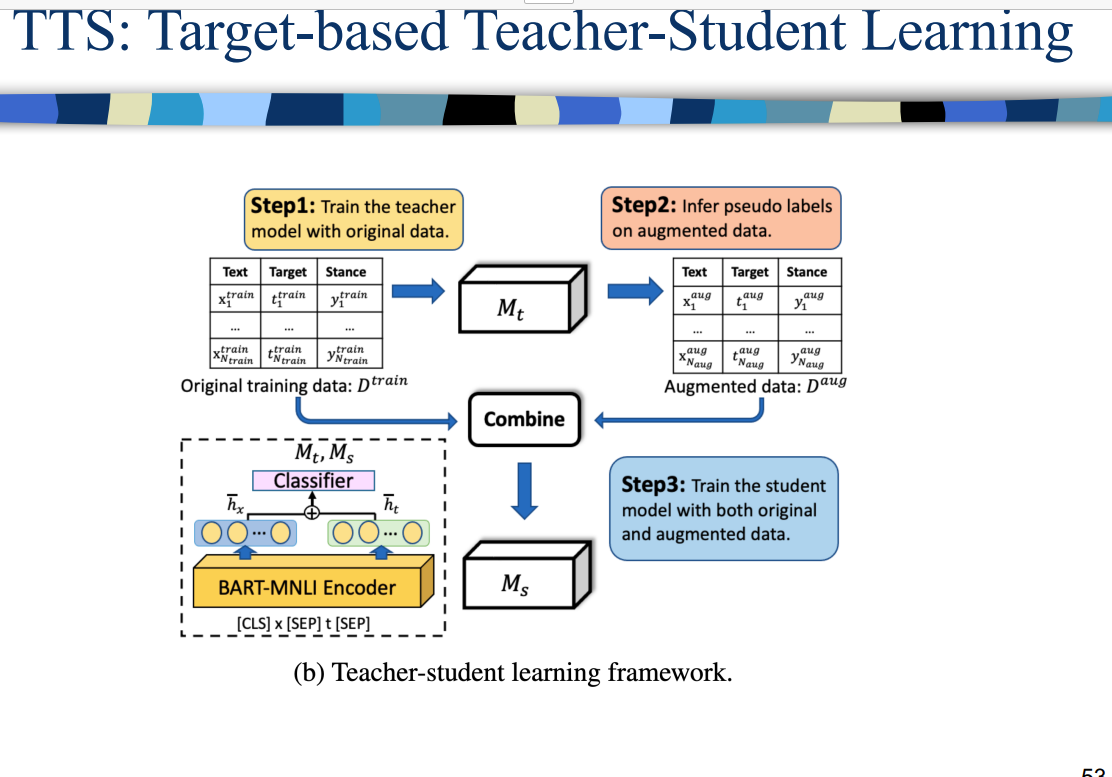

#Map psedo-labels on dataset - functions

In [ ]:
def map_label(row, predictions_df):
  row_map = predictions_df[predictions_df['text']==row['text']]
  if len(row_map)>1:
    row_map=row_map.iloc[0:1]

  row_index = row_map.index[0]
  if row_map.at[row_index, 'category'] == 'no':
    if type(row['all_categories'])==str:
      label = row['all_categories']
    else:
      label = row['all_categories'].values[0]
    is_confident=False
  else:
    if type(row_map.at[row_index, 'category']) == str:
      label = row_map.at[row_index, 'category']
    else:
      label = row_map.at[row_index, 'category'].values[0]
    is_confident=True
  return label, is_confident


def update_dataframe_with_pseudolabels(df, predictions_paired):
  predictions_df = pd.DataFrame(predictions_paired, columns=['text','category'])
  df['is_confident'] = ''
  df['all_categories'], df['is_confident'] =zip(* df.apply(lambda x: map_label(x, predictions_df),axis=1))
  df.drop_duplicates(subset=["text"], inplace=True)
  return df


# Train a student model un the pseudo-labeled + labeled data

- We train a student model on the labeled and pseudo-labeled data

- Last, we make the student model as the new teacher model and iterate by assigning new pseudo-labels on the unlabeled data until convergence.

- WE WILL EXPERIMENT WITH DIFFERENT STUDENT MODELS: mt5, flan

## load model function

In [ ]:
config.PRE_TRAINED_TOKENIZER_NAME, config.MODEL_ATE_PATH

('google/mt5-base',
 '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/models/ate_enroaug_cat_v6.pt')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config.PRE_TRAINED_TOKENIZER_NAME)

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
def load_model(type):
  if type=='student':
    model = MT5ForConditionalGeneration.from_pretrained(config.MODEL_BASE)
    model = model.to(config.DEVICE)
  else:
    model = T5ForConditionalGeneration.from_pretrained(config.MODEL_ATE_PATH)
    model = model.to(config.DEVICE)
  return model


## data prep - df & df_test_final (from lbl data)

In [ ]:
# df_lbl = df_lbl[:100]
# df_ulbl = df_ulbl[:100]
df_lbl, df_test_final = train_test_split(df_lbl, test_size=0.2, random_state=42)

In [ ]:
df = pd.concat([df_lbl[['text','all_categories','type']],df_ulbl[['text','all_categories','type']]], axis=0, ignore_index=True)

In [ ]:
df = clean_df(df,'text')
df_test_final = clean_df(df_test_final,'text')

In [ ]:
len(df), len(df_test_final)

(16742, 200)

In [ ]:
df = tokenize_df(df,'text', tokenizer)
df_test_final = tokenize_df(df_test_final,'text', tokenizer)

## Remove longer reviews

In [ ]:
config.MAX_SOURCE_LEN

512

In [ ]:
lengths = [len(tokenizer.encode(text)) for text in list(df['text'].values)]
df['text_len']=lengths

df_new = df[(df['text_len']<config.MAX_SOURCE_LEN) & (df['type']=='paseudo-labeled')]
len(df_new)

15843

In [ ]:
16742-15824

918

## get dataloder function

In [ ]:
def get_dataloader(df, batch_size):
  ds = ATEDataset(df)
  dl = DataLoader(ds, batch_size=batch_size, shuffle=True)
  return dl

## hyperparam functions

In [ ]:
def initialize_parameters(model, dataloader, optimizer_name, idx_lr):
  total_steps = len(dataloader) * config.EPOCHS

  if optimizer_name=='adam':
    optimizer = AdamW(model.parameters(), lr=config.LR[idx_lr], eps=config.EPS, correct_bias=False, no_deprecation_warning=True)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  elif optimizer_name=='ada':
    # optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=config.LEARNING_RATE[idx_lr], clip_threshold=1.0)  # noqa: E501
    optimizer = Adafactor(model.parameters(), relative_step=True, warmup_init=True, lr=None, clip_threshold=1.0)  # noqa: E501
    scheduler = AdafactorSchedule(optimizer)

  autoconfig = AutoConfig.from_pretrained(config.MODEL_BASE)
  return optimizer, scheduler, autoconfig


## eval

In [ ]:
def eval(model, df_val):
  dataloader = get_dataloader(df_val, config.BATCH_SIZE_TRAIN_LBL)

  model.eval()
  total_loss = 0
  total_f1 = 0
  recalls = []

  for step, batch in tqdm(enumerate(dataloader)):

    input_ids = batch['inputs_ids'].to(config.DEVICE)
    att_mask = batch['source_attention_mask'].to(config.DEVICE)
    labels = batch['lm_labels'].to(config.DEVICE)
    labels[labels == tokenizer.pad_token_id] = -100

    with torch.no_grad():
      generated_ids = model.generate(
                    input_ids=input_ids,
                    attention_mask=att_mask,
                    temperature=0.7,    # 0.6
                    use_cache=True,
                    penalty_alpha=1.1,  # 1.1
                    num_beams=5,
                    do_sample=True,
                    no_repeat_ngram_size=1,
                    num_return_sequences=1,
                    max_length=config.MAX_TARGET_LEN
                    )
      model_out = model(input_ids=input_ids, attention_mask=att_mask, labels=labels)

    loss = model_out.loss
    total_loss += loss.item()

    preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
    ground_truth = batch['target']

    preds_cleaned = [clean_predictions(p) for p in preds]
    target_cleaned = [clean_predictions(t) for t in ground_truth]

    recalls_current = [recall(preds_cleaned[idx],target_cleaned[idx]) for idx in range(0,len(ground_truth))]

    preds_cleaned_combined = [' and '.join(e) for e in preds_cleaned]
    targets_cleaned_combined = [' and '.join(t) for t in target_cleaned]

    f1_result = f1(preds_cleaned_combined, targets_cleaned_combined)

    total_f1 += f1_result
    recalls.extend(recalls_current)

    if step % 200 == 0 and not step == 0:
      print('\n  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader)))
      print('Ground truth:\n', ground_truth)
      print('Clean predictions generated:\n', preds_cleaned)
      print('F1:', f1_result)
      print('Recall:', recalls_current)
      print('')

    del input_ids, att_mask, labels, generated_ids, model_out

  avg_f1 = total_f1 / len(dataloader)
  avg_loss = total_loss / len(dataloader)
  avg_recall = np.mean(recalls)

  print("")
  print("Evaluation Summary Results")
  print("val loss | val f1 | val recall ")
  print(f"{avg_loss:.4f}     {avg_f1:.4f}   {avg_recall:.4f}")

  del dataloader, model
  return avg_loss, avg_f1, avg_recall

## train one epoch

In [ ]:
def filter_batch(batch):
  lbl_indices = (batch['was_labeled'] == True).nonzero(as_tuple=True)
  ulbl_indices = (batch['was_labeled'] == False).nonzero(as_tuple=True)

  input_ids = batch['inputs_ids']
  att_mask = batch['source_attention_mask']
  labels = batch['lm_labels']
  labels[labels == tokenizer.pad_token_id] = -100

  input_ids_lbl = input_ids[lbl_indices].to(config.DEVICE)
  input_ids_ulbl = input_ids[ulbl_indices].to(config.DEVICE)
  att_mask_lbl = att_mask[lbl_indices].to(config.DEVICE)
  att_mask_ulbl = att_mask[ulbl_indices].to(config.DEVICE)
  labels_lbl = labels[lbl_indices].to(config.DEVICE)
  labels_ulbl = labels[ulbl_indices].to(config.DEVICE)

  del input_ids, att_mask, labels, lbl_indices, ulbl_indices

  return input_ids_lbl,input_ids_ulbl, att_mask_lbl, att_mask_ulbl, labels_lbl, labels_ulbl

In [ ]:
def train_one_epoch(model_student, train_dataloader, optimizer, scheduler, criterion_lbl, criterion_ulbl, epoch, loss_weight):

    total_t0 = time.time()
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, config.EPOCHS))
    print('Training...')


    train_total_loss = 0
    model_student.train()

    for step, batch in tqdm(enumerate(train_dataloader)):

        # if step % 40 == 0 and not step == 0:
        #     print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        input_ids_lbl, input_ids_ulbl, att_mask_lbl, att_mask_ulbl, labels_lbl, labels_ulbl = filter_batch(batch)

        optimizer.zero_grad()

        if len(input_ids_lbl)>0:
          out_lbl = model_student(input_ids=input_ids_lbl,
                              attention_mask=att_mask_lbl,
                              labels=labels_lbl)
          loss_sup = criterion_lbl(out_lbl.logits.view(-1, out_lbl.logits.size(-1)), labels_lbl.view(-1))
        else:
          loss_sup=torch.zeros([1,1], device=config.DEVICE)

        if len(input_ids_ulbl)>0:
          out_ulbl = model_student(input_ids=input_ids_ulbl,
                              attention_mask=att_mask_ulbl,
                              labels=labels_ulbl)

          loss_unsup = criterion_ulbl(out_ulbl.logits.view(-1, out_ulbl.logits.size(-1)), labels_ulbl.view(-1))
        else:
          loss_unsup=torch.zeros([1,1], device=config.DEVICE)

        loss_agg = loss_weight * loss_sup  + (1-loss_weight) * torch.mean(loss_unsup)
        train_total_loss += loss_agg.item()

        loss_agg.backward()

        optimizer.step()
        torch.nn.utils.clip_grad_norm_(model_student.parameters(), 1.0)

        del input_ids_lbl, input_ids_ulbl, att_mask_lbl, att_mask_ulbl, labels_lbl, labels_ulbl

    avg_train_loss = train_total_loss / len(train_dataloader)

    training_time = format_time(time.time() - total_t0)

    print("")
    print("summary results")
    print("epoch | train loss | train time ")
    print(f"{epoch+1:5d} |  {avg_train_loss:.5f}  |  {training_time:}")

    return model_student, avg_train_loss, optimizer, scheduler, criterion_lbl, criterion_ulbl


## train loop

In [ ]:
def train_loop(model, df_train, df_val, loss_weight):
  best_model = model
  best_loss = float('-inf')
  best_f1 = 0

  train_dataloader = get_dataloader(df_train, config.BATCH_SIZE_TRAIN_LBL)

  criterion_lbl = nn.CrossEntropyLoss(ignore_index=-100, reduction='mean')
  criterion_ulbl = nn.CrossEntropyLoss(ignore_index=-100, reduction='none')
  optimizer, scheduler, autoconfig = initialize_parameters(model, train_dataloader, 'adam', 0)

  for epoch in range(config.EPOCHS):
    model, train_loss, optimizer, scheduler, criterion_lbl, criterion_ulbl = train_one_epoch(model, train_dataloader, optimizer, scheduler,criterion_lbl,criterion_ulbl, epoch, loss_weight)
    wandb.log({"Train Loss/Epoch":train_loss, "LR": optimizer.param_groups[-1]['lr']})

    eval_loss, eval_f1, eval_recalls = eval(model, df_val)
    wandb.log({"Eval Loss/Epoch":eval_loss, "Eval F1/Epoch":eval_f1, "Eval Recall/Epoch":eval_recalls})

    if eval_loss < best_loss:
      best_loss = eval_loss
      best_model = model
      best_f1 = eval_f1

  del train_dataloader, optimizer, scheduler, autoconfig, model, criterion_lbl, criterion_ulbl
  return best_model, best_loss, best_f1

## Utils functions for labels


To implement a confidence threshold for the T5 model's predictions, you need to calculate the confidence of the model in its output. In the case of T5 and similar sequence-to-sequence models, this is not as straightforward as models that output a single class with a probability distribution, because the output is a sequence of tokens.

We can  measure the difference between the log probabilities of the generated tokens and the log probabilities of the ground truth tokens. This comparison can provide insights into how well the model's predictions align with the actual (ground truth) data. This difference is essentially a measure of the model's prediction error in terms of probability.

In [ ]:
def calculate_confidence_average(tokenizer, generated_outputs, model_output):
  log_probs = torch.nn.functional.log_softmax(model_output.logits, dim=-1)
  token_confidences = log_probs.gather(2, generated_outputs.unsqueeze(-1)).squeeze(-1)

  mask = (generated_outputs != tokenizer.pad_token_id) & (generated_outputs != tokenizer.eos_token_id) & (generated_outputs != tokenizer.bos_token_id)
  masked_confidences = token_confidences * mask
  avg_confidence = masked_confidences.sum(dim=1) / mask.sum(dim=1)
  return avg_confidence

In [ ]:
def calculate_confidence_logprob_diff(model, model_outputs, generated_tokens, ground_truth_tokens):

  # Compute log probabilities
  log_probs = torch.nn.functional.log_softmax(model_outputs.logits, dim=-1)

  # Gather log probabilities for generated and ground truth tokens
  gen_log_probs = log_probs.gather(2, generated_tokens.unsqueeze(-1)).squeeze(-1)
  gt_log_probs = log_probs.gather(2, ground_truth_tokens.unsqueeze(-1)).squeeze(-1)

  # Calculate the difference between generated tokens and ground truth tokens
  diff = (gen_log_probs - gt_log_probs).abs().mean()
  return diff


def generate_pslabels_with_confidence(teacher_model, df_ulbl, tokenizer, confidence_threshold, method):
  teacher_model.eval()
  pseudo_labels = []

  for idx, row in df_ulbl.iterrows():
    input_ids = torch.tensor(row['inputs_ids']).to(config.DEVICE,dtype = torch.long)
    src_att_mask = torch.tensor(row['source_attention_mask']).to(config.DEVICE,dtype = torch.long)

    with torch.no_grad():
      model_out = teacher_model(input_ids=input_ids,attention_mask=src_att_mask, labels=input_ids)
      generated_outputs = teacher_model.generate(
                                                input_ids=input_ids,
                                                attention_mask=src_att_mask,
                                                temperature=0.7,
                                                use_cache=True,
                                                penalty_alpha=1.1,
                                                num_beams=10,
                                                do_sample=True,
                                                no_repeat_ngram_size=1,
                                                num_return_sequences=1,
                                                max_length=config.MAX_TARGET_LEN,
                                                )
      generated_tokens = generated_outputs[0]

    if method=='average':
      confidence = calculate_confidence_average(tokenizer, generated_outputs, model_out).item()
      if confidence >= confidence_threshold:
        prediction = tokenizer.decode(generated_outputs[0], skip_special_tokens=True)
        pseudo_labels.append((row['text'], prediction))

    elif method=='log_prob_diff':
      prediction = tokenizer.decode(generated_outputs[0], skip_special_tokens=True)
      prediction_ids, _ = tokenize_function(prediction, tokenizer, config.MAX_TARGET_LEN)
      prediction_ids = prediction_ids.to(config.DEVICE)

      ground_truth_tokens, _ = tokenize_function(row['all_categories'], tokenizer, config.MAX_TARGET_LEN)
      ground_truth_tokens = ground_truth_tokens.to(config.DEVICE)

      confidence = calculate_confidence_logprob_diff(teacher_model, model_out, prediction_ids, ground_truth_tokens).item()  #the difference should be very low

      if confidence <= confidence_threshold:
        pseudo_labels.append((row['text'], prediction))
        if idx%400==0 and idx!=0:
          print(f'{prediction=} [{confidence=}]')
      else:
        pseudo_labels.append((row['text'], 'no'))
  return pseudo_labels

## iterative process for student

In [ ]:
# Define a range of confidence thresholds to test
confidence_thresholds = np.linspace(0.5, 0.3, 2)
confidence_thresholds = np.append(confidence_thresholds, confidence_thresholds[-1])
confidence_thresholds, len(confidence_thresholds)

(array([0.5, 0.3, 0.3]), 3)

In [ ]:
wandb.init(project="ssl_ro", name='v5_mt5', config={
      "learning_rate": config.LR[0],
      "batch_size": config.BATCH_SIZE_TRAIN_LBL,
      "pseudolbl_datase":config.DATASET_pseudoLABELED_PATH_FINAL,
      "save_path_df": config.DATASET_FINAL_SAVE_PATH,
      "save_path_student": config.MODEL_STUDENT_SAVE_PATH,
      "confidence type": "log_prob_diff",
      "loss_sup_weight": config.LOSS_WEIGHT,
      "confidence_thresholds": confidence_thresholds,
      "temperature in generate": 0.7,
      "penalty alpha in generate":1.1,
      "num beams in generate": 5
      })

In [ ]:
def iterative_sudent_learning(df_train, df_val, confidence_thresholds, num_iterations, confidence_type):
  print('Start process')

  student_model = load_model(type='student')

  df_train = tokenize_df(df_train,'all_categories',tokenizer)
  df_val = tokenize_df(df_val,'all_categories',tokenizer)

  df_lbl = df_train[df_train['type']=='labeled']

  best_loss = float('+inf')
  df_final = df_train.copy()
  best_student = student_model

  for step in range(num_iterations):
    with torch.no_grad():
      torch.cuda.empty_cache()

    print(f'Iteration {step} ...')
    # extract from df_train weak pseudo-labeled examples as sub-dataframe for new pseudo labels generation
    df_ulbl_weak = df_train[df_train['type']=='paseudo-labeled']

    wandb.log({"Current #weaklabeled data": len(df_ulbl_weak)})

    # train the student for #n epochs
    student_model, current_loss, f1_score = train_loop(student_model, df_train, df_val, config.LOSS_WEIGHT)
    print(f'\n\n[{step}] Done training the student.\n')

    wandb.log({"Step Loss":current_loss, "Step F1": f1_score})

    # the best student becomes the teacher
    teacher_model = student_model

    # generate new pseudo labels (the confidence is also incremented)
    if step>0:
      confidence_threshold = confidence_thresholds[-1]
    else:
      confidence_threshold = confidence_thresholds[step]
    wandb.log({"Confidence": confidence_threshold})

    pseudo_labels =  generate_pslabels_with_confidence(teacher_model,
                                                      df_ulbl_weak,
                                                      tokenizer,
                                                      confidence_threshold,
                                                      confidence_type)
    print(f'\n\n[{step}] Done generating new pseudo-labels with high confidence.\n')

    # map pseudo_labels to weak labeled df
    df_ulbl_hard = update_dataframe_with_pseudolabels(df_ulbl_weak, pseudo_labels)

    if step>0:
      # keep only examples with high confidence
      df_ulbl_hard = df_ulbl_hard[df_ulbl_hard['is_confident']==True]
    else:
      # high confidence data will become train data, and low confidence will become pseudolabeled data
      df_ulbl_hard['type'] = ['labeled' if row['is_confident']==True else "paseudo-labeled" for idx,row in df_ulbl_hard.iterrows() ]

    # Remake dataframe for training with labeled and new confident pseudo-labels
    df_train = pd.concat([df_lbl, df_ulbl_hard], ignore_index=True, axis=0)

    print(f'\n\n[{step}] Done recreating the new dataframe.\n')

    print(f'Summary for Iteration [{step}]:\n- Loss = {current_loss}\n- F1={f1_score}\n- Current #instances in weak pseudo-labeled data: {len(df_ulbl_hard[df_ulbl_hard["type"]=="labeled"])}')

    if current_loss <= best_loss:
      best_loss=current_loss
      best_student=student_model
      df_final=df_train

      df_final.to_csv(config.DATASET_FINAL_SAVE_PATH)
      student_model.save_pretrained(config.MODEL_STUDENT_SAVE_PATH)
      print('- Updated best results')

  return df_final, best_student, best_loss

In [ ]:
config.MODEL_STUDENT_SAVE_PATH

'/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/models/ate_stud_ro_v1.pt'

## run

In [ ]:
df_train, df_val = train_test_split(df_new, test_size=0.1, random_state=42)
df_val.columns

Index(['text', 'all_categories', 'type', 'inputs_ids', 'source_attention_mask',
       'text_len'],
      dtype='object')

In [ ]:
len(df_train), len(df_val)

(14258, 1585)

In [ ]:
df_val.head()

,text,all_categories,type,inputs_ids,source_attention_mask,text_len
3524,Extract a list with the text spans that are as...,aprovizionare;utilizare,paseudo-labeled,"[[tensor(67893), tensor(259), tensor(262), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",174
972,Extract a list with the text spans that are as...,experienta;securitateare,paseudo-labeled,"[[tensor(67893), tensor(259), tensor(262), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",103
2929,Extract a list with the text spans that are as...,servicii;calitate-calitate,paseudo-labeled,"[[tensor(67893), tensor(259), tensor(262), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",237
11274,Extract a list with the text spans that are as...,disponibilitate;pret-cali,paseudo-labeled,"[[tensor(67893), tensor(259), tensor(262), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",51
7358,Extract a list with the text spans that are as...,personal,paseudo-labeled,"[[tensor(67893), tensor(259), tensor(262), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",34


In [ ]:
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

In [ ]:
confidence_thresholds

array([0.5, 0.3, 0.3])

In [ ]:
df_final, best_student, best_loss =  iterative_sudent_learning(df_train, df_val, confidence_thresholds, len(confidence_thresholds),'log_prob_diff')

Start process


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Iteration 0 ...

======== Epoch 1 / 3 ========
Training...


3565it [11:30,  5.16it/s]



summary results
epoch | train loss | train time 
    1 |  0.32519  |  0:11:31


201it [01:05,  3.12it/s]


  Batch   200  of    397.
Ground truth:
 ['produs;utilizare-calitate', 'utilizare;produs-calitate', 'produs;pret-calitate', 'marimi']
Clean predictions generated:
 [['produs', 'utilizare-calitate'], ['produs', 'utilizare-calitate'], ['produs', 'utilizare-calitate'], ['produs']]
F1: 0.125
Recall: [1.0, 0.0, 0.5, 0.0]



397it [02:09,  3.08it/s]



Evaluation Summary Results
val loss | val f1 | val recall 
1.0160     0.0801   0.3603

======== Epoch 2 / 3 ========
Training...


3565it [11:30,  5.16it/s]



summary results
epoch | train loss | train time 
    2 |  0.20952  |  0:11:31


201it [01:12,  2.71it/s]


  Batch   200  of    397.
Ground truth:
 ['disponibilitate', 'produs;utilizare asamblare', 'rezistenta', 'produs;utilizare-calitate']
Clean predictions generated:
 [['produs', 'utilizare-calitate'], ['produs', 'utilizare-calitate'], ['produs', 'utilizare-calitate'], ['produs', 'utilizare-calitate']]
F1: 0.1
Recall: [0.0, 0.5, 0.0, 1.0]



397it [02:22,  2.79it/s]



Evaluation Summary Results
val loss | val f1 | val recall 
0.9616     0.0499   0.3420

======== Epoch 3 / 3 ========
Training...


3565it [11:31,  5.16it/s]



summary results
epoch | train loss | train time 
    3 |  0.18580  |  0:11:32


201it [01:12,  2.75it/s]


  Batch   200  of    397.
Ground truth:
 ['calitate;pret-calitate', 'pret;experienta', 'produs;livrare-calitate', 'produs;pret-calitate']
Clean predictions generated:
 [['produs', 'pret-calitate'], ['produs', 'utilizare-calitate'], ['produs', 'pret-calitate'], ['produs', 'utilizare-calitate']]
F1: 0.0
Recall: [0.5, 0.0, 0.5, 0.5]



397it [02:22,  2.78it/s]



Evaluation Summary Results
val loss | val f1 | val recall 
0.8668     0.0988   0.3886


[0] Done training the student.

prediction='produs;pret-calitate' [confidence=0.4997524619102478]
prediction='produs;pret-calitate' [confidence=0.0]
prediction='produs;confort-calitate' [confidence=0.027476757764816284]
prediction='produs;utilizare-calitate' [confidence=0.0]


[0] Done generating new pseudo-labels with high confidence.



[0] Done recreating the new dataframe.

Summary for Iteration [0]:
- Loss = 1.015960302100674
- F1=0.08005877413937872
- Current #instances in weak pseudo-labeled data: 1920
- Updated best results
Iteration 1 ...

======== Epoch 1 / 3 ========
Training...


3535it [13:25,  4.39it/s]



summary results
epoch | train loss | train time 
    1 |  0.30895  |  0:13:26


201it [01:05,  3.10it/s]


  Batch   200  of    397.
Ground truth:
 ['produs;utilitate asamblare', 'organizare', 'magazin;produs-calitate', 'produs;pret-calitate']
Clean predictions generated:
 [['produs', 'utilizare-calitate'], ['produs', 'utilizare-calitate'], ['produs', 'utilizare-calitate'], ['produs', 'utilizare-calitate']]
F1: 0.0
Recall: [0.5, 0.0, 0.0, 0.5]



397it [02:09,  3.06it/s]



Evaluation Summary Results
val loss | val f1 | val recall 
0.9179     0.1128   0.3817

======== Epoch 2 / 3 ========
Training...


3535it [13:24,  4.40it/s]



summary results
epoch | train loss | train time 
    2 |  0.28033  |  0:13:24


201it [01:07,  2.97it/s]


  Batch   200  of    397.
Ground truth:
 ['servicii;personal-calitate', 'personal;suport', 'asamblare;utilitate', 'rezistenta;produs']
Clean predictions generated:
 [['produs', 'utilizare-calitate'], ['produs'], ['produs', 'utilizare-calitate'], ['produs', 'confort-calitate']]
F1: 0.0
Recall: [0.0, 0.0, 0.0, 0.5]



397it [02:12,  3.00it/s]



Evaluation Summary Results
val loss | val f1 | val recall 
0.8737     0.1162   0.3981

======== Epoch 3 / 3 ========
Training...


3535it [13:24,  4.39it/s]



summary results
epoch | train loss | train time 
    3 |  0.27287  |  0:13:24


201it [01:07,  2.99it/s]


  Batch   200  of    397.
Ground truth:
 ['produs;material-calitate', 'produs;calitate-calitate', 'produs;confort-calitate', 'produs;utilizare-calitate']
Clean predictions generated:
 [['produs', 'utilizare-calitate'], ['produs', 'pret-calitate'], ['produs', 'confort-calitate'], ['produs', 'utilizare-calitate']]
F1: 0.41666666666666663
Recall: [0.5, 0.5, 1.0, 1.0]



397it [02:12,  2.99it/s]



Evaluation Summary Results
val loss | val f1 | val recall 
0.9133     0.1387   0.4019


[1] Done training the student.

prediction='produs;pret-calitate' [confidence=0.0]
prediction='produs;confort-calitate' [confidence=0.25681284070014954]
prediction='produs;pret-calitate' [confidence=0.0]


[1] Done generating new pseudo-labels with high confidence.



[1] Done recreating the new dataframe.

Summary for Iteration [1]:
- Loss = 0.9178648972391181
- F1=0.1127623845507976
- Current #instances in weak pseudo-labeled data: 0
- Updated best results
Iteration 2 ...

======== Epoch 1 / 3 ========
Training...


266it [00:52,  5.08it/s]



summary results
epoch | train loss | train time 
    1 |  0.03251  |  0:00:52


201it [01:03,  3.13it/s]


  Batch   200  of    397.
Ground truth:
 ['produs;personal', 'produs;utilizare-calitate', 'organizare', 'produs;utilizare-calitate']
Clean predictions generated:
 [['produs', 'pret-calitate'], ['produs', 'pret-calitate'], ['personal'], ['produs', 'utilizare-calitate']]
F1: 0.3333333333333333
Recall: [0.5, 0.5, 0.0, 1.0]



397it [02:05,  3.16it/s]



Evaluation Summary Results
val loss | val f1 | val recall 
1.4716     0.1452   0.4003

======== Epoch 2 / 3 ========
Training...


266it [00:51,  5.16it/s]



summary results
epoch | train loss | train time 
    2 |  0.02251  |  0:00:52


201it [01:02,  3.14it/s]


  Batch   200  of    397.
Ground truth:
 ['utilizare;produs-calitate', 'produs;pret-calitate', 'produs;utilizare-calitate', 'produs;organizare-calitate']
Clean predictions generated:
 [['produs', 'utilizare-calitate'], ['produs'], ['produs', 'pret-calitate'], ['produs', 'pret-calitate']]
F1: 0.0
Recall: [0.0, 0.5, 0.5, 0.5]



397it [02:04,  3.19it/s]



Evaluation Summary Results
val loss | val f1 | val recall 
1.5303     0.1535   0.3946

======== Epoch 3 / 3 ========
Training...


266it [00:51,  5.14it/s]



summary results
epoch | train loss | train time 
    3 |  0.01849  |  0:00:52


201it [01:03,  3.28it/s]


  Batch   200  of    397.
Ground truth:
 ['varietate;experienta-calitate', 'produs', 'produs;pret-calitate', 'magazin;pret-calitate']
Clean predictions generated:
 [['produs', 'pret-calitate'], ['comanda'], ['produs', 'pret-calitate'], ['comanda']]
F1: 0.16666666666666666
Recall: [0.0, 0.0, 1.0, 0.0]



397it [02:05,  3.16it/s]



Evaluation Summary Results
val loss | val f1 | val recall 
1.4836     0.1493   0.3883


[2] Done training the student.

prediction='produs' [confidence=0.0]


[2] Done generating new pseudo-labels with high confidence.



[2] Done recreating the new dataframe.

Summary for Iteration [2]:
- Loss = 1.5303111825354154
- F1=0.1534634760705288
- Current #instances in weak pseudo-labeled data: 0


## save and test

In [ ]:
df_final

In [ ]:
# df_final.to_csv(config.DATASET_FINAL_SAVE_PATH)
# best_student.save_pretrained(config.MODEL_STUDENT_SAVE_PATH)

In [ ]:
df_test_final = tokenize_df(df_test_final,'all_categories',tokenizer)

In [ ]:
test_loss, test_f1, test_recall = eval(best_student, df_test_final)

23it [00:07,  3.12it/s]

In [ ]:
wandb.finish()

# Compare the initial pslbl dataset with the final one

In [ ]:
DATASET_pseudoLABELED_PATH_FINAL = '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/dataset/ro/pseudolabeled_reviews.csv'
DATASET_FINAL_SAVE_PATH = '/content/gdrive/MyDrive/Colab Notebooks/cercetare ABSA/dataset/ro/labeled_reviews_by_student.csv'